In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset paths
dataset_base = "/content/drive/MyDrive/Dataset 1 (Simplex)-20250316T164808Z-001/Dataset 1 (Simplex)"
train_data_path = os.path.join(dataset_base, "Train data")
test_data_path = os.path.join(dataset_base, "Test data")
negative_data_path = os.path.join(train_data_path, "Negative data")
positive_data_path = os.path.join(train_data_path, "Positive data")

# Verify paths and list some images
for path in [dataset_base, train_data_path, test_data_path, negative_data_path, positive_data_path]:
    if os.path.exists(path):
        print(f"✅ Found: {path}")
        print("Sample images:", os.listdir(path)[:5])  # List first 5 files
    else:
        print(f"❌ Path not found: {path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Found: /content/drive/MyDrive/Dataset 1 (Simplex)-20250316T164808Z-001/Dataset 1 (Simplex)
Sample images: ['simpleTestFullSizeAllPotholesSortedFullAnnotation.txt', 'simpleTrainFullPhotosSortedFullAnnotations.txt', 'Test data', 'Train data']
✅ Found: /content/drive/MyDrive/Dataset 1 (Simplex)-20250316T164808Z-001/Dataset 1 (Simplex)/Train data
Sample images: ['Negative data', 'Positive data']
✅ Found: /content/drive/MyDrive/Dataset 1 (Simplex)-20250316T164808Z-001/Dataset 1 (Simplex)/Test data
Sample images: ['G0335487.JPG', 'G0145175.JPG', 'G9029451.JPG', 'G0335489.JPG', 'G0145165.JPG']
✅ Found: /content/drive/MyDrive/Dataset 1 (Simplex)-20250316T164808Z-001/Dataset 1 (Simplex)/Train data/Negative data
Sample images: ['G0088518.JPG', 'G0515929.JPG', 'G0495893.JPG', 'G0063704.JPG', 'G0485849.JPG']
✅ Found: /content/drive/MyDrive/Dataset 1 (Simplex)-20250316T

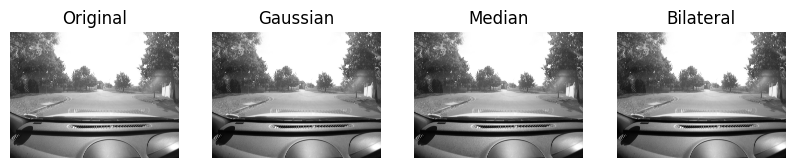

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to apply filters
def apply_filters(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale

    # Apply filters
    gaussian = cv2.GaussianBlur(image, (5, 5), 0)
    median = cv2.medianBlur(image, 5)
    bilateral = cv2.bilateralFilter(image, 9, 75, 75)

    # Plot results
    plt.figure(figsize=(10, 4))
    titles = ['Original', 'Gaussian', 'Median', 'Bilateral']
    images = [image, gaussian, median, bilateral]

    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')

    plt.show()

# Select a sample image from test data
sample_image_path = os.path.join(test_data_path, os.listdir(test_data_path)[0])
apply_filters(sample_image_path)


In [ ]:
!pip install opencv-python numpy matplotlib PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 95.5 MB/s eta 0:00:00


In [ ]:
!pip install PyWavelets


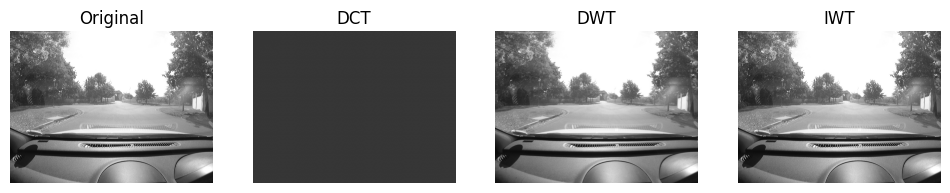

In [ ]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Function to apply DCT
def apply_dct(image):
    image = np.float32(image) / 255.0  # Normalize
    dct = cv2.dct(image)  # Apply DCT
    return dct

# Function to apply DWT
def apply_dwt(image):
    coeffs2 = pywt.dwt2(image, 'haar')  # Apply DWT with Haar wavelet
    LL, (LH, HL, HH) = coeffs2
    return LL  # Return approximation coefficients

# Function to apply IWT
def apply_iwt(image):
    coeffs2 = (image, (np.zeros_like(image), np.zeros_like(image), np.zeros_like(image)))
    iwt = pywt.idwt2(coeffs2, 'haar')  # Inverse DWT
    return iwt

# Function to compress image using all methods
def compress_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale

    dct_image = apply_dct(image)
    dwt_image = apply_dwt(image)
    iwt_image = apply_iwt(dwt_image)  # Apply IWT on DWT result

    # Plot results
    plt.figure(figsize=(12, 4))
    titles = ['Original', 'DCT', 'DWT', 'IWT']
    images = [image, dct_image, dwt_image, iwt_image]

    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')

    plt.show()

# Select a sample image from test data
sample_image_path = os.path.join(test_data_path, os.listdir(test_data_path)[0])
compress_image(sample_image_path)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import os
import cv2

# Function to extract statistical features from an image
def extract_features(image):
    image = np.float32(image) / 255.0  # Normalize

    # Apply transformations
    dct_features = cv2.dct(image).flatten()[:100]  # Extract first 100 DCT coefficients
    coeffs2 = pywt.dwt2(image, 'haar')  # Apply DWT
    LL, (LH, HL, HH) = coeffs2
    dwt_features = LL.flatten()[:100]  # Extract first 100 DWT coefficients

    # Combine features
    features = np.hstack([dct_features, dwt_features])
    return features

# Load dataset and extract features
X, y = [], []

for label, folder in enumerate([negative_data_path, positive_data_path]):  # 0: Negative, 1: Positive
    for filename in os.listdir(folder):
        image_path = os.path.join(folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            features = extract_features(image)
            X.append(features)
            y.append(label)

# Convert to NumPy arrays
X, y = np.array(X), np.array(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
svm_model = SVC(kernel='linear')
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier(n_estimators=100)

# Train models
svm_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.85        67
           1       0.76      0.83      0.79        46

    accuracy                           0.82       113
   macro avg       0.82      0.82      0.82       113
weighted avg       0.83      0.82      0.82       113

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.66      0.75        67
           1       0.63      0.85      0.72        46

    accuracy                           0.73       113
   macro avg       0.75      0.75      0.73       113
weighted avg       0.77      0.73      0.74       113

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82        67
           1       0.73      0.76      0.74        46

    accuracy                           0.79       113
   macro avg       0.78 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import numpy as np
import os
import cv2

# Image size and batch size
IMG_SIZE = (64, 64)
BATCH_SIZE = 32

# Function to load images and labels
def load_images_from_folder(folder, label):
    images, labels = [], []
    for filename in os.listdir(folder):
        image_path = os.path.join(folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, IMG_SIZE)  # Resize image
            images.append(image)
            labels.append(label)
    return images, labels

# Load dataset
X, y = [], []
neg_images, neg_labels = load_images_from_folder(negative_data_path, 0)
pos_images, pos_labels = load_images_from_folder(positive_data_path, 1)

X.extend(neg_images + pos_images)
y.extend(neg_labels + pos_labels)

# Convert to NumPy arrays
X = np.array(X).reshape(-1, 64, 64, 1) / 255.0  # Normalize & reshape
y = np.array(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN Model
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN
cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=BATCH_SIZE)

# Predictions
y_pred_cnn = (cnn_model.predict(X_test) > 0.5).astype("int32").flatten()

# Evaluation
print("CNN Classification Report:\n", classification_report(y_test, y_pred_cnn))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5815 - loss: 0.6824 - val_accuracy: 0.7611 - val_loss: 0.5302
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7647 - loss: 0.5113 - val_accuracy: 0.8496 - val_loss: 0.4190
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8642 - loss: 0.3646 - val_accuracy: 0.8407 - val_loss: 0.3494
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8509 - loss: 0.3520 - val_accuracy: 0.8584 - val_loss: 0.3778
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8728 - loss: 0.3127 - val_accuracy: 0.8496 - val_loss: 0.3262
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9212 - loss: 0.2248 - val_accuracy: 0.8584 - val_loss: 0.3269
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9044 - loss: 0.2053 - val_accuracy: 0.8496 - val_loss: 0.3107
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9191 - loss: 0.2113 - val_accuracy: 0.8496 - v

Dataset Loaded Successfully. Shape: (561, 64, 64, 1)
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - loss: 0.6601 - val_loss: 0.6083
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5931 - val_loss: 0.5839
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5757 - val_loss: 0.5763
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5683 - val_loss: 0.5724
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5672 - val_loss: 0.5730
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5640 - val_loss: 0.5707
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5627 - val_loss: 0.5675
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5596 - val_loss: 0.5665
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5591 - val_loss: 0.5653
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5576 - val_loss: 0.5637
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


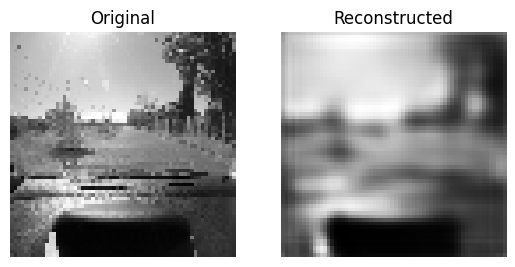

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Load dataset again (grayscale images)
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        image_path = os.path.join(folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, (64, 64))
            images.append(image)
    return np.array(images)

# Load images
X_train_neg = load_images(negative_data_path)
X_train_pos = load_images(positive_data_path)

# Ensure both arrays are not empty
if len(X_train_neg) == 0 or len(X_train_pos) == 0:
    raise ValueError("One of the datasets (Negative/Positive) is empty. Check dataset paths.")

# Concatenate images
X_train_auto = np.concatenate((X_train_neg, X_train_pos), axis=0)
X_train_auto = X_train_auto.reshape(-1, 64, 64, 1) / 255.0  # Normalize

print("Dataset Loaded Successfully. Shape:", X_train_auto.shape)

# Define Autoencoder model
input_img = Input(shape=(64, 64, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train Autoencoder
autoencoder.fit(X_train_auto, X_train_auto, epochs=10, batch_size=32, validation_split=0.1)

# Test Autoencoder on a sample image
sample_image = X_train_auto[0]
reconstructed = autoencoder.predict(sample_image.reshape(1, 64, 64, 1)).reshape(64, 64)

# Plot original and reconstructed image
plt.subplot(1, 2, 1)
plt.imshow(sample_image.reshape(64, 64), cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed, cmap='gray')
plt.title("Reconstructed")
plt.axis('off')

plt.show()


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd


In [ ]:
# Generate classification reports
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
report_cnn = classification_report(y_test, y_pred_cnn, output_dict=True)


In [ ]:
# Extract relevant metrics (Accuracy, Precision, Recall, F1 Score)
models = ["SVM", "Decision Tree", "Random Forest", "CNN"]
reports = [report_svm, report_dt, report_rf, report_cnn]

# Prepare data for DataFrame
metrics_data = []
for model, report in zip(models, reports):
    accuracy = report["accuracy"]
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1_score = report["weighted avg"]["f1-score"]

    metrics_data.append([model, accuracy, precision, recall, f1_score])

# Convert to Pandas DataFrame
df_metrics = pd.DataFrame(metrics_data, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])


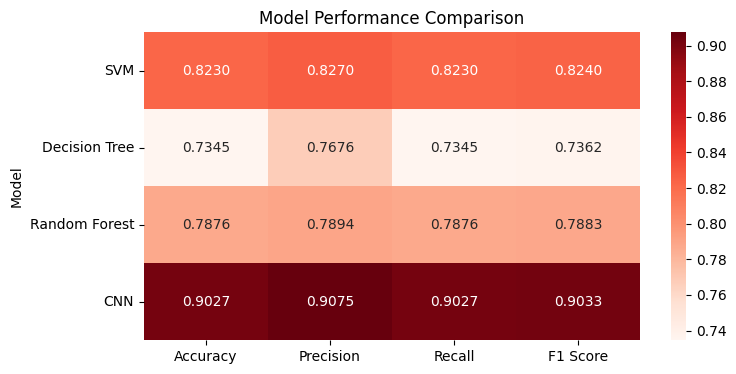

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.heatmap(df_metrics.set_index("Model"), annot=True, cmap="Reds", fmt=".4f")
plt.title("Model Performance Comparison")
plt.show()


In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━ 234.0/363.4 MB 152.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.3 MB/s eta 0:00:00
ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, plea

In [ ]:
!pip install roboflow ultralytics


In [ ]:
!pip install ultralytics roboflow


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path
dataset_path = "/content/drive/MyDrive/Pothole_Dataset/Pothole.v1-raw.yolov8"

# Check if the dataset folder exists
if os.path.exists(dataset_path):
    print("Dataset found! ✅")
    print("Files inside the dataset folder:", os.listdir(dataset_path))
else:
    print("❌ Dataset not found! Check the path and try again.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset found! ✅
Files inside the dataset folder: ['data.yaml', 'README.dataset.txt', 'README.roboflow.txt', 'train', 'test', 'valid']


In [ ]:
import os

dataset_path = "/content/drive/MyDrive/Pothole_Dataset/Pothole.v1-raw.yolov8"

# List files
print("Dataset Structure:")
print(os.listdir(dataset_path))


Dataset Structure:
['data.yaml', 'README.dataset.txt', 'README.roboflow.txt', 'train', 'test', 'valid']


In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs Available:", torch.cuda.device_count())


CUDA Available: True
Number of GPUs Available: 1


In [ ]:
from ultralytics import YOLO
import torch

# Load YOLOv8 model (starting with pre-trained weights)
model = YOLO("yolov8n.pt")

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Train the model
model.train(data="/content/drive/MyDrive/Pothole_Dataset/Pothole.v1-raw.yolov8/data.yaml",
            epochs=50, imgsz=640, device=device)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 316MB/s]


Using device: cuda
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Pothole_Dataset/Pothole.v1-raw.yolov8/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fals

100%|██████████| 755k/755k [00:00<00:00, 126MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 375MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Pothole_Dataset/Pothole.v1-raw.yolov8/train/labels.cache... 465 images, 0 backgrounds, 0 corrupt: 100%|██████████| 465/465 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Pothole_Dataset/Pothole.v1-raw.yolov8/valid/labels.cache... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.08G       1.73      2.707      1.574          3        640: 100%|██████████| 30/30 [00:31<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

                   all        133        330    0.00649      0.785      0.167     0.0884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.6G      1.524      2.021      1.438          1        640: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

                   all        133        330      0.433      0.167      0.171      0.078



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       2.6G      1.617      1.949      1.509          5        640: 100%|██████████| 30/30 [00:14<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


                   all        133        330      0.314      0.291      0.207      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       2.6G      1.599      1.899      1.495          4        640: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]

                   all        133        330      0.362      0.364      0.294      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       2.6G      1.548      1.712      1.469          1        640: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


                   all        133        330      0.545      0.406      0.434      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.62G      1.529      1.661      1.431          3        640: 100%|██████████| 30/30 [00:11<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

                   all        133        330      0.623      0.491      0.548      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.63G      1.522      1.574      1.435          5        640: 100%|██████████| 30/30 [00:11<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        133        330      0.533      0.508      0.454      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.65G      1.472      1.476      1.376          5        640: 100%|██████████| 30/30 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


                   all        133        330       0.57      0.427      0.441      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.65G      1.479      1.519      1.409          7        640: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        133        330      0.635      0.506      0.563      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.65G      1.468      1.429      1.374          2        640: 100%|██████████| 30/30 [00:12<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

                   all        133        330      0.686      0.511      0.597      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.65G      1.429      1.402      1.371          5        640: 100%|██████████| 30/30 [00:12<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        133        330      0.683      0.589      0.647      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.67G      1.433      1.395      1.372          3        640: 100%|██████████| 30/30 [00:11<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

                   all        133        330      0.637      0.558      0.592      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.67G      1.423      1.318       1.36          6        640: 100%|██████████| 30/30 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        133        330       0.64      0.552       0.62      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.67G      1.443       1.37      1.394          2        640: 100%|██████████| 30/30 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]

                   all        133        330      0.707      0.564      0.637      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.67G      1.343      1.232      1.305          3        640: 100%|██████████| 30/30 [00:14<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        133        330      0.681      0.588      0.664      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.67G      1.328      1.168      1.302          6        640: 100%|██████████| 30/30 [00:11<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]

                   all        133        330      0.675      0.615      0.665      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.67G      1.291      1.201      1.293          1        640: 100%|██████████| 30/30 [00:11<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        133        330      0.732      0.591      0.694      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.67G      1.385      1.243      1.374          2        640: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]

                   all        133        330      0.715      0.691      0.734      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.67G      1.306      1.175      1.298          2        640: 100%|██████████| 30/30 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]

                   all        133        330       0.76      0.627      0.729      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.67G      1.277      1.123      1.261          6        640: 100%|██████████| 30/30 [00:12<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        133        330      0.719      0.603      0.686       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.67G      1.276      1.093      1.257          4        640: 100%|██████████| 30/30 [00:12<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        133        330      0.722      0.624      0.704      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.67G      1.267      1.084      1.251         13        640: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

                   all        133        330      0.635      0.579      0.633      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.67G       1.21      1.043      1.229          3        640: 100%|██████████| 30/30 [00:12<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

                   all        133        330      0.723      0.609      0.682      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.67G      1.241       1.07       1.26          4        640: 100%|██████████| 30/30 [00:12<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

                   all        133        330      0.767      0.617      0.698      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.68G      1.208      1.055      1.216          2        640: 100%|██████████| 30/30 [00:12<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        133        330      0.763      0.644      0.736      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.68G      1.226      1.008      1.223          6        640: 100%|██████████| 30/30 [00:12<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

                   all        133        330      0.714      0.648      0.692      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.68G      1.202      1.058      1.228          1        640: 100%|██████████| 30/30 [00:14<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all        133        330      0.784      0.627      0.717      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.68G      1.207      1.022      1.237          3        640: 100%|██████████| 30/30 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


                   all        133        330      0.742      0.664      0.733      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.68G      1.176     0.9738      1.204          1        640: 100%|██████████| 30/30 [00:12<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        133        330      0.728      0.661      0.711       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.68G      1.178     0.9499      1.194         12        640: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

                   all        133        330      0.792      0.606      0.716      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.68G      1.178     0.9427      1.206          6        640: 100%|██████████| 30/30 [00:12<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        133        330      0.765      0.648      0.732      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.68G      1.209      1.005      1.255          1        640: 100%|██████████| 30/30 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        133        330      0.813      0.636      0.737      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       2.7G       1.13     0.8901      1.171          6        640: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        133        330      0.738      0.676      0.746      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.71G      1.148      0.916      1.173         13        640: 100%|██████████| 30/30 [00:12<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        133        330      0.816      0.655      0.766      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.73G      1.106     0.8776      1.154          1        640: 100%|██████████| 30/30 [00:12<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

                   all        133        330      0.846      0.624      0.742       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.73G      1.122     0.8621      1.167          4        640: 100%|██████████| 30/30 [00:12<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        133        330      0.794      0.639      0.765       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.73G      1.132     0.9209      1.196          2        640: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        133        330      0.804       0.67      0.766      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.73G      1.061     0.8712       1.15          5        640: 100%|██████████| 30/30 [00:12<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all        133        330      0.839      0.648      0.772       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.73G      1.037     0.8025      1.123          3        640: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

                   all        133        330      0.805      0.652      0.761      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.73G       1.05     0.8036      1.118          4        640: 100%|██████████| 30/30 [00:12<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all        133        330       0.83      0.667      0.768      0.487


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.75G     0.9933     0.8445      1.101          2        640: 100%|██████████| 30/30 [00:14<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

                   all        133        330      0.853      0.621      0.728      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.75G       0.98     0.7637      1.101          1        640: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

                   all        133        330      0.834      0.661      0.751      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.75G     0.9897     0.7584      1.095          3        640: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

                   all        133        330      0.796      0.685      0.762      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.75G       1.07     0.8056      1.236          1        640: 100%|██████████| 30/30 [00:11<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


                   all        133        330      0.877      0.626      0.772      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.75G     0.9447     0.6795      1.054          1        640: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

                   all        133        330      0.768      0.682      0.768      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.75G     0.9502     0.6741      1.064          4        640: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

                   all        133        330      0.799      0.698      0.781      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.75G     0.9233     0.6684      1.047          1        640: 100%|██████████| 30/30 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        133        330      0.785      0.686      0.772      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.75G     0.9477     0.6792      1.093          3        640: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        133        330      0.818      0.697      0.776      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.75G     0.9104     0.6346      1.041          5        640: 100%|██████████| 30/30 [00:12<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        133        330      0.826      0.691      0.781      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.75G     0.8974     0.6118      1.028          1        640: 100%|██████████| 30/30 [00:13<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        133        330      0.816      0.687      0.778      0.505



50 epochs completed in 0.220 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


                   all        133        330      0.816      0.688      0.778      0.505
Speed: 0.4ms preprocess, 5.4ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x783b8b37e790>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
import os

weights_dir = "runs/detect/train/weights"
print("Saved Model Weights:", os.listdir(weights_dir))


Saved Model Weights: ['best.pt', 'last.pt']



image 1/1 /content/drive/MyDrive/Pothole_Dataset/Pothole.v1-raw.yolov8/test/images/img-362_jpg.rf.6363ec1a7603671afb1887d9f16c03e7.jpg: 416x640 1 pothole, 42.4ms
Speed: 2.2ms preprocess, 42.4ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


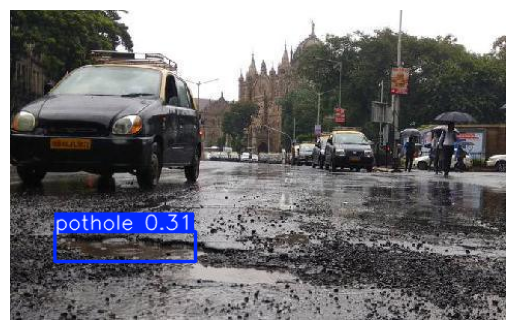

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the best trained model
model = YOLO("runs/detect/train/weights/best.pt")

# Path to a test image
test_image_path = "/content/drive/MyDrive/Pothole_Dataset/Pothole.v1-raw.yolov8/test/images/img-362_jpg.rf.6363ec1a7603671afb1887d9f16c03e7.jpg"  # Update with an actual test image path

# Run inference
results = model(test_image_path)

# Display the result
res_plotted = results[0].plot()  # Draw bounding boxes
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
